In [4]:
#Basic Initialization

#Code:
 #setting path in colab
 #mount the drive first
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
import os

#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "CIS680HW/HW4b/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  !touch 'new_file_test.txt'
  print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

Mounted at /content/drive/
working directory/content/drive/My Drive/CIS680HW/HW4b/empty text file created. You can also run !pwd command to confirm working directory.


In [5]:
cd /content/drive/MyDrive/CIS680HW/HW4b

/content/drive/MyDrive/CIS680HW/HW4b


In [17]:
from BoxHead import BoxHead
from utils import output_decoding, IOU_vectorized, IOU
from pretrained_models import pretrained_models_680
from dataset import BuildDataLoader, BuildDataset
import torch.optim as optim
from torchvision.models.detection.image_list import ImageList
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

In [ ]:
imgs_path = root_dir + 'CIS680HW' + '/HW3/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

In [ ]:
# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
boxHead = BoxHead()
boxHead=boxHead.to(device)
loadModel = True
model_path = "./model_4B_v6.pth"
if loadModel:
  boxHead.load_state_dict(torch.load(model_path))
boxHead = boxHead.eval()

pretrained_path='models/checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path, eval=True)
keep_topK = 200

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
predicted_boxes = []
predicted_classes = []
predicted_scores = []
ground_truth = []
ground_truth_boxes = []
for i, batch in enumerate(test_loader):
  images = batch['images'].to(device)
  gt_labels = batch['labels']
  boxes = batch['bboxes']
  # Take the features from the backbone
  backout = backbone(images)
  #pdb.set_trace()
  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)

  #The final output is
  # A list of proposal tensors: list:len(bz){(keep_topK,4)}
  proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]

  # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
  fpn_feat_list= list(backout.values())

  class_gt,class_gt_box = boxHead.create_ground_truth(proposals,gt_labels,boxes)
  #print(class_gt[class_gt>0].shape)
  feature_vectors=boxHead.MultiScaleRoiAlign(fpn_feat_list.copy(),proposals.copy())

  class_logits,box_preds=boxHead(feature_vectors)
  boxes_pred,scores,labels=boxHead.postprocess_detections(class_logits,box_preds,proposals,conf_thresh=0.7, keep_num_preNMS=50, keep_num_postNMS=5)

  predicted_boxes.append(boxes_pred[0])
  predicted_scores.append(scores[0])
  predicted_classes.append(labels[0])
  ground_truth.append(gt_labels[0])
  ground_truth_boxes.append(boxes[0])


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/drive/.shortcut-targets-by-id/1f8u4JI31JnsegNbVS3RIFA-w-pW653GC/HW4b/utils.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_pred = torch.tensor(boxes_pred).to(device)
/content/drive/.shortcut-targets-by-id/1f8u4JI31JnsegNbVS3RIFA-w-pW653GC/HW4b/utils.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proposals = torch.tensor(proposals).to(device)
/content/drive

In [20]:
import pdb
def average_precision(predicted_boxes, predicted_labels, confidence_scores, ground_truth,ground_truth_boxes,clas):
    all_iou_scores = []
    all_confidence_scores = []
    all_actual_detections = []
    cur_idx = 0
    num_gt_of_clas = 0
    thresh = 0.50
    for i, (box_preds,pred_labels,conf_scores,gt,gt_box) in enumerate(zip(predicted_boxes, predicted_labels, confidence_scores, ground_truth,ground_truth_boxes)):
        gt_idx = np.argwhere(gt==clas)
        pred_idx = np.argwhere(pred_labels==clas)
        num_gt_of_clas+=gt_idx.shape[0]
        #print(len(all_confidence_scores))
        #print(len(all_iou_scores))
        #print(len(all_actual_detections))
        if(gt_idx.shape[0]>0 and pred_idx.shape[0]>0):
          # Calculating AP
          gt_idx = gt_idx[:,0]
          pred_idx = pred_idx[:,0]
          iou_scores = IOU_vectorized(box_preds[pred_idx], gt_box[gt_idx]).numpy()
          max_iou_scores = np.max(iou_scores, axis=0)
          gt_iou_scores = np.argmax(iou_scores,axis=0)
          all_iou_scores += max_iou_scores.tolist()
          all_confidence_scores += conf_scores[pred_idx].tolist()
          detected_gts = np.unique(gt_iou_scores)
          actual_detections = np.zeros(len(max_iou_scores)).tolist()
          
          # obtaining true predicted ground truths
          for lbl in detected_gts:
            idxs = np.argwhere(gt_iou_scores==lbl)[0]
            if idxs.shape[0]>0:
              idx = np.argmax(max_iou_scores[idxs])
              if(max_iou_scores[idxs[idx]]>=thresh):
                actual_detections[idxs[idx]] = 1
          all_actual_detections += actual_detections
        elif(pred_idx.shape[0]>0):
          iou_scores = np.zeros(pred_idx.shape[0])
          pred_idx = pred_idx[:,0]
          all_iou_scores += iou_scores.tolist()
          actual_detections = np.zeros(len(iou_scores)).tolist()
          all_confidence_scores += conf_scores[pred_idx].tolist()
          all_actual_detections += actual_detections

    # print(all_confidence_scores)
    # print(all_iou_scores)
    # print(all_actual_detections)
    # print(num_gt_of_clas)
    order = (np.array(all_confidence_scores)).argsort()[::-1]
    sorted_iou_scores = np.array(all_iou_scores)[order]
    #print(sorted_iou_scores)
    sorted_actual_detections = np.array(all_actual_detections)[order]
    tp = np.cumsum(sorted_iou_scores > thresh)
    fp = np.cumsum(sorted_iou_scores < thresh)
    ttp = np.cumsum(sorted_actual_detections)
    precision = tp / (fp + tp)
    recall = ttp / num_gt_of_clas
    # print(precision)
    # print(recall)
    # print(ttp)
    # print(sorted_iou_scores)
    # print(tp)
    # print(fp)
    average_precision = 0
    prev_recall = 0
    for j in range(len(recall)-1):
        if precision[j]>precision[j+1]:
            average_precision+=(recall[j] - prev_recall)*precision[j]
            prev_recall = recall[j]
    
    if(len(recall)!=0):
        average_precision += precision[len(recall)-1]*(recall[len(recall)-1]- prev_recall)
    else:
        average_precision = 0
    return average_precision,precision,recall

In [82]:
def IOU2(boxA, boxB):
    ##################################
    # computes the IOU between the boxA, boxB boxes
    ##################################
    x1 = boxA[0]
    y1 = boxA[1]
    x2 = boxA[2]
    y2 = boxA[3]
    
    x3 = boxB[0]
    y3 = boxB[1]
    x4 = boxB[2]
    y4 = boxB[3]

    x1_int = np.maximum(x1, x3)
    y1_int = np.maximum(y1, y3)
    x2_int = np.minimum(x2, x4)
    y2_int = np.minimum(y2, y4)
    int_area = np.clip(x2_int - x1_int,0,None) * np.clip(y2_int - y1_int,0,None)
    u_area = (x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - int_area
    return int_area / u_area

def average_precision2(predicted_boxes, predicted_labels, confidence_scores, ground_truth,ground_truth_boxes,clas):
    all_iou_scores = []
    all_confidence_scores = []
    all_actual_detections = []
    cur_idx = 0
    num_gt_of_clas = 0
    thresh = 0.50
    found_gt = np.zeros(4)
    for i, (box_preds, conf_scores) in enumerate(zip(predicted_boxes, confidence_scores)):
        temp_iou_scores = []
        for gt_box in ground_truth_boxes:
            temp_iou_scores.append(IOU2(box_preds, gt_box))
        temp_iou_scores = np.array(temp_iou_scores) 
        a = np.where(temp_iou_scores > thresh, temp_iou_scores, 0)
        
        if np.sum(a) == 0:
          print(i, "False Positive")
          new_detections = 0
        else:
          print(i, "True Positive")
          res = np.argmax(a)
          print(res)
          temp_found_gt = np.copy(found_gt)
          temp_found_gt[res] = 1
          new_detections = np.sum(temp_found_gt) - np.sum(found_gt)
          found_gt = temp_found_gt

        all_confidence_scores.append(conf_scores)
        max_iou_score = np.max(a)
        all_iou_scores.append(max_iou_score)
        all_actual_detections.append(new_detections)
        # gt_idx = np.argwhere(gt==clas)
        # pred_idx = np.argwhere(pred_labels==clas)
        # num_gt_of_clas+=gt_idx.shape[0]
        # #print(len(all_confidence_scores))
        # #print(len(all_iou_scores))
        # #print(len(all_actual_detections))
        # if(gt_idx.shape[0]>0 and pred_idx.shape[0]>0):
        #   # Calculating AP
        #   gt_idx = gt_idx[:,0]
        #   pred_idx = pred_idx[:,0]
        #   iou_scores = IOU_vectorized(box_preds[pred_idx], gt_box[gt_idx]).numpy()
        #   max_iou_scores = np.max(iou_scores, axis=0)
        #   gt_iou_scores = np.argmax(iou_scores,axis=0)
        #   all_iou_scores += max_iou_scores.tolist()
        #   all_confidence_scores += conf_scores[pred_idx].tolist()
        #   detected_gts = np.unique(gt_iou_scores)
        #   actual_detections = np.zeros(len(max_iou_scores)).tolist()
          
        #   # obtaining true predicted ground truths
        #   for lbl in detected_gts:
        #     idxs = np.argwhere(gt_iou_scores==lbl)[0]
        #     if idxs.shape[0]>0:
        #       idx = np.argmax(max_iou_scores[idxs])
        #       if(max_iou_scores[idxs[idx]]>=thresh):
        #         actual_detections[idxs[idx]] = 1
        #   all_actual_detections += actual_detections
        # elif(pred_idx.shape[0]>0):
        #   iou_scores = np.zeros(pred_idx.shape[0])
        #   pred_idx = pred_idx[:,0]
        #   all_iou_scores += iou_scores.tolist()
        #   actual_detections = np.zeros(len(iou_scores)).tolist()
        #   all_confidence_scores += conf_scores[pred_idx].tolist()
    #       all_actual_detections += actual_detections

    # # print(all_confidence_scores)
    # # print(all_iou_scores)
    # # print(all_actual_detections)
    # # print(num_gt_of_clas)
    order = (np.array(all_confidence_scores)).argsort()[::-1]
    sorted_iou_scores = np.array(all_iou_scores)[order]
    sorted_actual_detections = np.array(all_actual_detections)[order]
    tp = np.cumsum(sorted_iou_scores > thresh)
    fp = np.cumsum(sorted_iou_scores < thresh)
    ttp = np.cumsum(sorted_actual_detections)
    precision = ttp / (fp + tp)
    recall = ttp / 4
    print(order)
    print(precision)
    print(recall)
    print(np.array(all_confidence_scores)[order])
    # print(ttp)
    # print(sorted_iou_scores)
    # print(tp)
    # print(fp)
    average_precision = 0
    prev_recall = 0
    for j in range(len(recall)-1):
        if precision[j]>precision[j+1]:
            average_precision+=(recall[j] - prev_recall)*precision[j]
            prev_recall = recall[j]
    
    if(len(recall)!=0):
        average_precision += precision[len(recall)-1]*(recall[len(recall)-1]- prev_recall)
    else:
        average_precision = 0
    return average_precision,precision,recall

In [83]:
predicted_boxes = np.array([[10, 25, 40, 75],
                   [20, 30, 40, 95],
                   [10, 45, 30, 60],
                   [0, 50, 35, 60],
                   [40, 30, 50, 40],
                   [10, 70, 70, 90],
                   [55, 5, 60, 35],
                   [30, 0, 75, 55],
                   [80, 50, 85, 90],
                   [5, 25, 30, 70]])

ground_truth_boxes = np.array([[20, 30, 40, 70],
                   [10, 50, 30, 60],
                   [40, 30, 50, 40],
                   [0, 50, 35, 60]])

predicted_labels = np.expand_dims(np.ones(10), axis=1)
ground_truth_labels = np.expand_dims(np.ones(4), axis=1)

confidences = np.array([0.95, 0.1, 0.05, 0.65, 0.85, 0.55, 0.15, 0.5, 0.25, 0.45])

average_precision,precision,recall  = average_precision2(predicted_boxes, predicted_labels, confidences, ground_truth_labels, ground_truth_boxes, 1)

0 True Positive
0
1 True Positive
0
2 True Positive
1
3 True Positive
3
4 True Positive
2
5 False Positive
6 False Positive
7 False Positive
8 False Positive
9 False Positive
[0 4 3 5 7 9 8 6 1 2]
[1.         1.         1.         0.75       0.6        0.5
 0.42857143 0.375      0.33333333 0.4       ]
[0.25 0.5  0.75 0.75 0.75 0.75 0.75 0.75 0.75 1.  ]
[0.95 0.85 0.65 0.55 0.5  0.45 0.25 0.15 0.1  0.05]


In [80]:
print(average_precision)

0.875


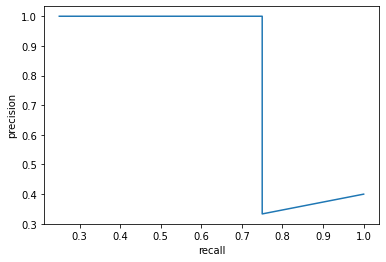

In [85]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

In [ ]:
ap1,p1,r1 = average_precision(predicted_boxes, predicted_classes, predicted_scores, ground_truth, ground_truth_boxes, 1)
ap2,p2,r2 = average_precision(predicted_boxes, predicted_classes, predicted_scores, ground_truth ,ground_truth_boxes, 2)
ap3,p3,r3 = average_precision(predicted_boxes, predicted_classes, predicted_scores, ground_truth, ground_truth_boxes, 3)
print("Mean Average Precision: {}".format((ap1+ap2+ap3)/3))
print("Average Precision for Class 1: {}".format(ap1))
print("Average Precision for Class 2: {}".format(ap2))
print("Average Precision for Class 3: {}".format(ap3))

Mean Average Precision: 0.5713636515861412
Average Precision for Class 1: 0.587810875458435
Average Precision for Class 2: 0.4204398726160233
Average Precision for Class 3: 0.7058402066839654


Text(0, 0.5, 'Precision')

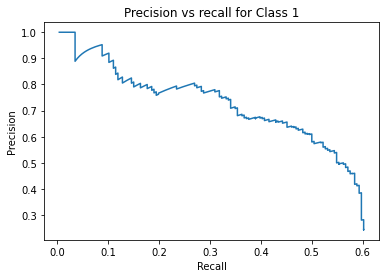

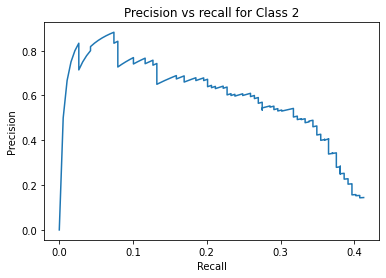

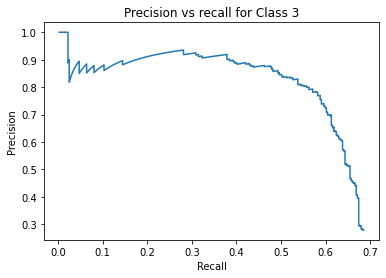

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(r1,p1)
plt.title('Precision vs recall for Class 1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure()
plt.plot(r2,p2)
plt.title('Precision vs recall for Class 2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.figure()
plt.plot(r3,p3)
plt.title('Precision vs recall for Class 3')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [ ]:
# def average_precision(test_loader, predicted_boxes, predicted_labels, confidence_scores, clas):
#     num_pred_of_clas = np.sum(predicted_labels == clas)
#     all_iou_scores = np.zeros(num_pred_of_clas)
#     all_confidence_scores = np.zeros(num_pred_of_clas)
#     cur_idx = 0
#     num_gt_of_clas = 0

#     for i, batch in enumerate(test_loader):
#         gt_labels = batch['labels'][0]
#         gt_boxes = batch['bboxes'][0]

#         pred_boxes = predicted_boxes[i]
#         pred_labels = predicted_labels[i]
#         c_scores = confidence_scores[i]
        
#         num_gt_of_clas += np.sum(gt_labels==clas)
#         gt_idx = np.argwhere(gt_labels==clas)
#         pred_idx = np.argwhere(pred_labels==clas)

#         iou_scores = IOU_vectorized(pred_boxes[pred_idx], gt_boxes[gt_idx])
#         max_iou_scores = np.max(iou_scores, axis=0)

#         num_preds = max_iou_scores.shape[0]
#         all_iou_scores[cur_idx:(cur_idx + num_preds)] = max_iou_scores
#         all_confidence_scores[cur_idx:(cur_idx + num_preds)] = c_scores

#     order = all_confidence_scores.argsort()[::-1]
#     sorted_iou_scores = all_iou_scores[order]

#     tp = np.cumsum(sorted_iou_scores > 0.5)
#     fp = np.sumsum(sorted_iou_scores < 0.5)
#     precision = tp / (fp + tp)
#     recall = tp / num_gt_of_clas

#     average_precision = 0
#     prev_recall = 0
#     for j in range(len(recall)-1):
#         if precision[j]>precision[j+1]:
#             average_precision+=(recall[j] - prev_recall)*precision[j]
#             prev_recall = recall[j]
    
#     if(len(recall)!=0):
#         average_precision += precision[len(recall)-1]*(recall[len(recall)-1]- prev_recall)
#     else:
#         average_precision = 0
#     return average_precision
  